In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

### Loading the modified dataset

In [2]:
df = pd.read_csv('dataset/data_merged.csv')
#list(df.columns)
#del df['mode']
#del df['key_6_yr']
#del df['popularity_yr']
#del df['popularity_ar']

In [3]:
df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,speechiness,...,valence_yr,popularity_yr,mode,key_0_yr,key_1_yr,key_2_yr,key_3_yr,key_4_yr,key_5_yr,key_6_yr
0,0.0131,0.2560,182347,0.895,0,0.000106,0.0821,-4.860,29,0.0707,...,0.583424,35.272231,1,0,0,1,0,0,0,0
1,0.9800,0.2770,206972,0.145,0,0.879000,0.1110,-19.898,0,0.0845,...,0.432251,3.672500,1,1,0,0,0,0,0,0
2,0.7950,0.6850,314667,0.483,0,0.878000,0.1130,-10.202,1,0.0337,...,0.447291,7.707000,1,0,0,0,1,0,0,0
3,0.6560,0.7880,179747,0.808,0,0.000000,0.1540,-6.590,0,0.0395,...,0.447291,7.707000,1,0,0,0,1,0,0,0
4,0.3020,0.0753,498560,0.150,0,0.884000,0.1210,-16.705,0,0.0371,...,0.443625,3.419500,1,1,0,0,0,0,0,0


In [5]:
# Separating columns containing features and output. Also, changing values in the output
# to labels 1 (popular) and 0 (not popular) using threshold arrived at from Billboard charts. 
X = df[df.columns.difference(['popularity'])]
y = pd.cut(x=df["popularity"], bins=[-1,42,100], labels=[0,1])

# Splitting data in to test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Trial Random Forest

In [8]:
# Initializing and training the Random Forest Classifier with default hyperparameters. 
rnd_clf=RandomForestClassifier(n_jobs=-1) # n_jobs=-1 uses all cores of the CPU
rnd_clf.fit(X_train, y_train)

# Prediction on test data.
y_pred_rf=rnd_clf.predict(X_test)

print('\033[1mClassification Report')
print('\033[0m')
print(classification_report(y_test, y_pred_rf))

print('\033[1mConfusion Matrix')
print('\033[0m')
print(confusion_matrix(y_test, y_pred_rf))

Classification Report

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     25942
           1       0.85      0.69      0.76      8504

    accuracy                           0.89     34446
   macro avg       0.88      0.82      0.85     34446
weighted avg       0.89      0.89      0.89     34446

Confusion Matrix

[[24908  1034]
 [ 2639  5865]]


### Extra Trees Classifier
We can also try to use the ExtraTreesClassifier which randomizes the number of features used to split each node. We see that the performance is slightly worse than using just a Random Forest. 

In [9]:
ext_clf=ExtraTreesClassifier(n_jobs=-1)
ext_clf.fit(X_train, y_train)
y_pred_ext=ext_clf.predict(X_test)

print('\033[1mClassification Report')
print('\033[0m')
print(classification_report(y_test, y_pred_ext))

print('\033[1mConfusion Matrix')
print('\033[0m')
print(confusion_matrix(y_test, y_pred_ext))

Classification Report

              precision    recall  f1-score   support

           0       0.90      0.95      0.93     25942
           1       0.82      0.68      0.74      8504

    accuracy                           0.88     34446
   macro avg       0.86      0.82      0.83     34446
weighted avg       0.88      0.88      0.88     34446

Confusion Matrix

[[24699  1243]
 [ 2735  5769]]


### Randomized Grid Search
Next step is to perform randomized grid search to find optimal hyperparameters. 

In [27]:
# Initializing a set of hyperparameters. Randomized Grid Search will then iterate through random combinations of these
# to find optimal parameters.

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)] # Number of Decisions Trees in the forest
max_features = ['auto', 'sqrt']                                                 # Max features used to split at each node
max_depth = np.linspace(20,100,5).tolist()                                      # Max depth of each tree
max_depth.append(None) 
bootstrap = [True, False]
min_samples_split = [2, 5, 10]                                                  # Minimum samples required to split at a node
min_samples_leaf = [1, 2, 4]                                                    # Minimum samples required for a leaf node

In [28]:
# Parameter Grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [32]:
# Running the Randomized Grid Search. 
rfc=RandomForestClassifier(random_state=42)
random_rfc = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
                                random_state=42, n_jobs = -1)
random_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 131.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20.0, 40.0, 60.0, 80.0,
                                                      100.0, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=42, verbose=2)

In [11]:
print('\033[1mBest Parameters')
print('\033[0m')
random_rfc.best_params_

Best Parameters



NameError: name 'random_rfc' is not defined

### Final Run with Best Parameters

In [6]:
rnd_clf=RandomForestClassifier(n_estimators=400, max_depth=20, max_features='sqrt', criterion='gini', min_samples_leaf=4,
                               min_samples_split=2, bootstrap=False, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf=rnd_clf.predict(X_test)

In [7]:
from joblib import dump
dump(rnd_clf, "Saved models/RFC")

['Saved models/RFC']

In [8]:
print('\033[1mClassification Report')
print('\033[0m')
print(classification_report(y_test, y_pred_rf))

Classification Report

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     25874
           1       0.87      0.70      0.78      8572

    accuracy                           0.90     34446
   macro avg       0.89      0.83      0.86     34446
weighted avg       0.90      0.90      0.90     34446



In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
# predict probabilities
lr_probs = rnd_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
lr_auc

0.9453353978689432

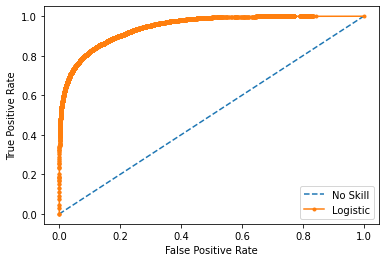

In [10]:
from matplotlib import pyplot
from numpy import sqrt, argmax, save
import numpy as np
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
np.save("fpr_RFC", fpr)
np.save("tpr_RFC", tpr)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

SVM: f1=0.777 auc=0.883
0.24885327759391512


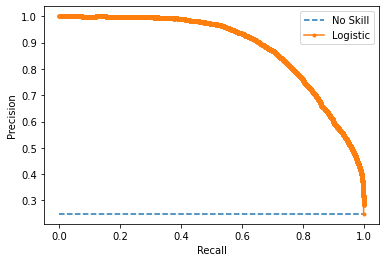

In [12]:
from sklearn.metrics import auc, precision_recall_curve, f1_score
from matplotlib import pyplot
lr_precision, lr_recall, thresholds = precision_recall_curve(y_test, lr_probs)
np.save("lrp_RFC", lr_precision)
np.save("lrr_RFC", lr_recall)
lr_f1, lr_auc = f1_score(y_test, y_pred_rf), auc(lr_recall, lr_precision)
# summarize scores
print('SVM: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
fscore = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
print(no_skill)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()